<a href="https://colab.research.google.com/github/janzika/MATH3261-5285/blob/main/tracer_advection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://raw.githubusercontent.com/climate-in-the-cloud/workshop/master/tracer-advection/cats-eye.png)

# Lab F2: Tracer advection

In this lab, we will introduce the Dedalus solver to explores some concepts from Partial Different Equations:

- Constructing basis functions and domains
- Boundary conditions and initial value problems
- Formulating the problem and writing equations in Dedalus

The example we will be looking at is the advection diffusion equation.

To use this notebook on your local machine, you will need to have Python 3 and the latest version of [Dedalus](http://dedalus-project.org/) installed.

If you do not have Python 3 and Dedalus, you can run the lab on [Google Colaboratory](http://colab.research.google.com) from your web browser.


##Colab and Google Drive

Colab integrates with Google Drive, so you can save your notebook, figures, and movies to your own Drive if you would like. This is not required to run the lab, because figures and movies will be saved to the Colab virtual machine and displayed in your browser.

If you would like to save your notebook, copy and paste the following code snippet to mount your Google Drive in Colab. The command will send you to a new browser window (make sure you allow pop-ups) to give permission for Colab to access your Drive. You can then locate your Google Drive by navigating to `drive/'My Drive'`:

```
from google.colab import drive
drive.mount('/content/drive')
!ls drive/'My Drive'
```

You can also save your notebook to Google Drive, or download a copy of the notebook file, using the **File Menu** in the top left corner.

# Background

## Passive tracer advection

![](https://raw.githubusercontent.com/climate-in-the-cloud/workshop/master/tracer-advection/mixing-rod.png)
*Figure: Lab experiment showing stretching and mixing of a viscous fluid (sugar syrup) by a stirring rod. Dye has been added to the fluid to help visualize the flow. Experiments by E. Gouillart and O. Dauchot (CEA Saclay).*

In real laboratory experiments, we often use colored dye to help visualize flows. By adding a few drops of tracer, we can see the complicated flow patterns and structures that form. In nature, the same thing happens with naturally occuring chemicals, for example water vapour (in the atmosphere) or chlorophyll (in the ocean).

We will use a similar technique in our simulation using a kind of numerical dye called a *passive tracer*. Specifically, we will solve the *advection-diffusion equation in 2 dimensions*:

$$
\partial_t \, C + \mathbf{u} \cdot \nabla C = K \nabla^2 C,
$$

where $C(x,y,t)$ is the concentration of a dye that is moved around by the flow $\mathbf{u}$: it is *tracer* because it allows us to trace the evolution of parcels of fluid, and it is *passive* because it does not affect the evolution of the flow in any way.

We can write the advection-diffusion equation in Lagrangian form as

$$
\frac{D C}{D t} = K \nabla^2 C,
$$

where $D/Dt = \partial_t + \mathbf{u \cdot \nabla}$ is the advective derivative. In the limit of no diffusion, $K \rightarrow 0$, an initial tracer distribution $C (\mathbf{x}, 0)$ will be moved around by the flow $\mathbf{u}$ without any change, i.e. it is conserved by the flow. In the absence of diffusion, the tracer would form narrower and narrower filaments with stronger and stronger gradients in $C$, without ever smoothing out. Eventually the filaments would become smaller than the gridsize of our domain, and the simulation would crash.

To avoid this, we have added a diffusion term $K \nabla^2 C$ on the right-hand side of the passive tracer evolution equation, with a very small value for the diffusivity $K$. The effect of this term is to smooth out small-scale gradients of $C$, ensuring that the simulation remains stable. Thus, the initial tracer distribution will eventually be dispersed throughout the domain, regardless of the advecting flow field.  

## The Childress-Soward cat's-eye flow

So far we have not said anything about the flow $\mathbf{u}$ moving the tracer around. In this experiment we will use a periodic 2D velocity field described by the one-parameter family of streamfunctions

$$
\psi(x,y) = \sin x \, \sin y + \epsilon \, \cos x \, \cos y.
$$

The streamfunction $\psi(x,y)$ describes the path taken by particles advected by the (time-independent) flow. Constant values of $\psi(x,y)$ are the _streamlines_ of the flow, that is, contours that are always directed along the velocity field at each point in space. The velocities in the $x$ and $y$ direction are calculated from the derivatives of the streamfunction:

$$
u(x,y) = - \partial_y \, \psi, \qquad v(x,y) = \partial _x \, \psi.
$$

The parameter $\epsilon$ controls the shape of the flow: for $\epsilon = 0$, the flow forms a periodic array of closed cells, for $\epsilon = 1$, the flow is a parallel shear flow, and for values of $0 < \epsilon < 1$, the flow forms elongated "cat's eye" ellipses.

## References

- S. Childress and A. M. Soward, [Scalar transport and alpha-effect for a family of cat’s-eye flows](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/scalar-transport-and-alphaeffect-for-a-family-of-catseye-flows/A649BCF133BB25DA3B80239024945C77), J. Fluid Mech. 205, 99 (1989).

# Experimental setup

## Installing Dedalus

We will use a python library called [Dedalus](http://dedalus-project.org/) to solve the advection diffusion equation.

We start by installing Dedalus on the Colab virtual machine. This might take a few minutes.

**Type SHIFT+ENTER (or click RUN from the menu above) to execute each cell.**

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/v2_master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

## Libraries

First we import the necessary libraries and call some commands so we can suppress some logging messages and plot figures in the notebook window.

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

## Plotting the flow field

The next cell plots the streamlines and vector fields for different values of the parameter $\epsilon$.

[None, Text(0.5, 1.0, 'ε = 1.0')]

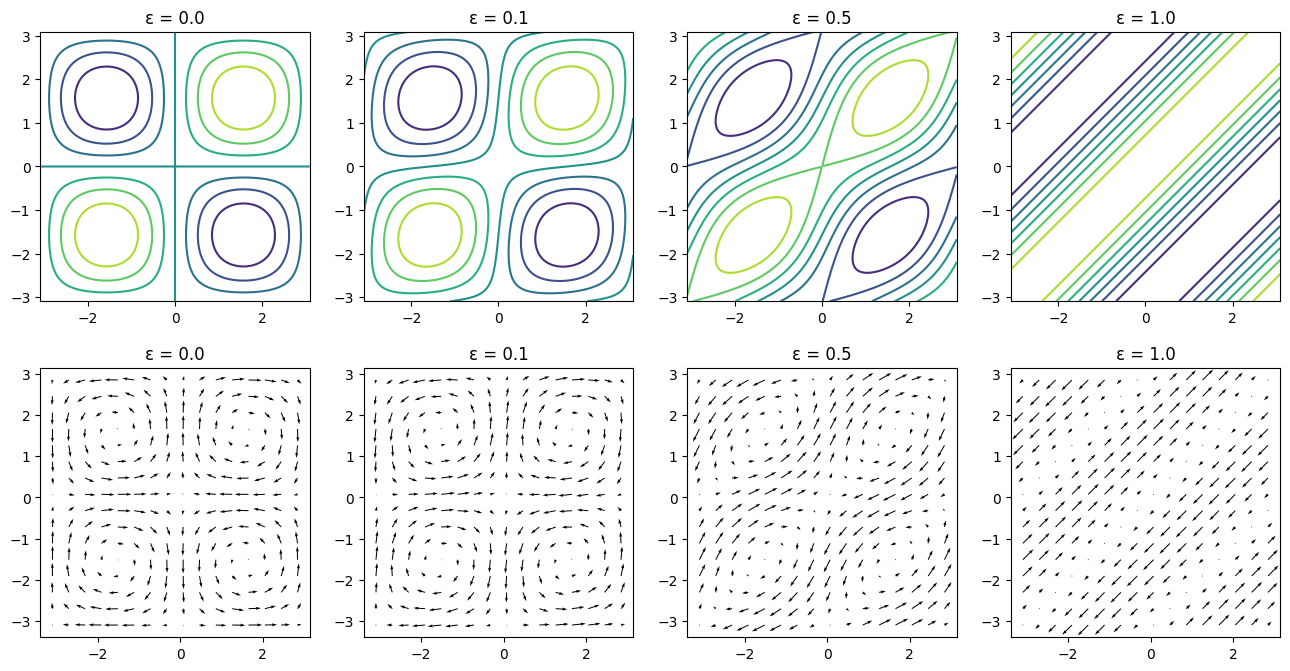

In [3]:
# four sample values of the parameter epsilon
eps1 = 0.0
eps2 = 0.1
eps3 = 0.5
eps4 = 1.0

# plot the flow field
n = 128
x,y = np.linspace(-np.pi,np.pi,n)[1:-1, None], np.linspace(-np.pi,np.pi,n)[None,1:-1]
xf,yf = x.flatten(),y.flatten()
xx,yy = np.meshgrid(xf,yf,indexing='ij')               # fine grid for contour plots
XX,YY = np.meshgrid(xf[0:n:8],yf[0:n:8],indexing='ij') # course grid for quiver plots

f = plt.figure(figsize=(16,8))

ax = f.add_subplot(2,4,1)
ax.contour(xx, yy, np.sin(xx)*np.sin(yy) + eps1*np.cos(xx)*np.cos(yy))
ax.set(aspect=1,title='ε = ' + str(eps1))

ax = f.add_subplot(2,4,2)
ax.contour(xx, yy, np.sin(xx)*np.sin(yy) + eps2*np.cos(xx)*np.cos(yy))
ax.set(aspect=1,title='ε = ' + str(eps2))

ax = f.add_subplot(2,4,3)
ax.contour(xx, yy, np.sin(xx)*np.sin(yy) + eps3*np.cos(xx)*np.cos(yy))
ax.set(aspect=1,title='ε = ' + str(eps3))

ax = f.add_subplot(2,4,4)
ax.contour(xx, yy, np.sin(xx)*np.sin(yy) + eps4*np.cos(xx)*np.cos(yy))
ax.set(aspect=1,title='ε = ' + str(eps4))

ax = f.add_subplot(2,4,5)
ax.quiver(XX, YY, -np.sin(XX)*np.cos(YY) + eps1*np.cos(XX)*np.sin(YY),np.cos(XX)*np.sin(YY) - eps1*np.sin(XX)*np.cos(YY))
ax.set(aspect=1,title='ε = ' + str(eps1))

ax = f.add_subplot(2,4,6)
ax.quiver(XX, YY, -np.sin(XX)*np.cos(YY) + eps2*np.cos(XX)*np.sin(YY),np.cos(XX)*np.sin(YY) - eps2*np.sin(XX)*np.cos(YY))
ax.set(aspect=1,title='ε = ' + str(eps2))

ax = f.add_subplot(2,4,7)
ax.quiver(XX, YY, -np.sin(XX)*np.cos(YY) + eps3*np.cos(XX)*np.sin(YY),np.cos(XX)*np.sin(YY) - eps3*np.sin(XX)*np.cos(YY))
ax.set(aspect=1,title='ε = ' + str(eps3))

ax = f.add_subplot(2,4,8)
ax.quiver(XX, YY, -np.sin(XX)*np.cos(YY) + eps4*np.cos(XX)*np.sin(YY),np.cos(XX)*np.sin(YY) - eps4*np.sin(XX)*np.cos(YY))
ax.set(aspect=1,title='ε = ' + str(eps4))

---
### Exercise

- Starting from the streamfunction

$$
\psi(x,y) = \sin x \, \sin y + \epsilon \, \cos x \, \cos y.
$$

calculate explicit expressions for the velocities in the $x$ and $y$ directions,

$$
u(x,y) = - \partial_y \, \psi, \qquad v(x,y) = \partial _x \, \psi.
$$

- Verify that the velocity field is *incompressible*, i.e.

$$
\partial_x \, u + \partial_y \, v = 0.
$$

- Calculate the *vorticity* associated with a 2D velocity field

$$
\boldsymbol{\omega} = \mathbf {\nabla \times v}
$$

where $\mathbf{v} = \left( u(x,y), v(x,y), 0 \right)$ is the velocity. Show that only the $z$-componet of $\boldsymbol{\omega}$ is non-zero, with value

$$
\omega_3 = \partial_x \, v - \partial_y \, u.
$$

Create a plot showing the vorticity for the cat's-eye flow for different values of $\epsilon$. (You can copy and modify the python code in the cell above.)

## Initital value problem

In this problem we will specify the initial concentration $C = C_0(x)$ at $t = 0$. In general, this will be a function of space. Here, we will choose a particular form for the initial concentration so that it is confined to the centre of the domain:

$$
C_0 (x,y) = \frac{1}{2 a} \log \left( 1 + \frac{\cosh^2 a}{\cosh^2 a \sqrt{x^2 + y^2}} \right).
$$

Varying $a$ makes the initial concentration narrow or smaller, as needed. In the next cell, we will plot different initial conditions to get a sense of how they depend on $a$. We'll just plot the variation of the initial condition in $x$ (i.e. a slice along $y = 0$).

**Don't forget to type SHIFT+ENTER (or click RUN from the menu above) to execute each cell.**

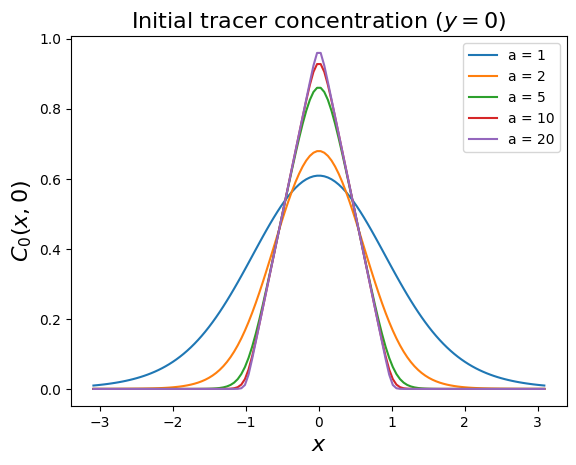

In [4]:
# resolution, x-axis, and legend for plots
n = 128
x = np.linspace(-np.pi,np.pi,n)[1:-1, None].flatten()
legend = []

# plot initial concentration values C_0 for a range of a-values
for a in [1,2,5,10,20]:
    C = np.log( 1 + np.cosh(a)**2 / np.cosh(a*x)**2 )/(2*a)
    plt.plot(x,C)
    legend.append('a = ' + str(a))

plt.title(r'Initial tracer concentration ($y = 0$)',fontsize=16)
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$C_0(x,0)$',fontsize=16)
plt.legend(legend)

## Formulating the problem

We can write the 2D advection-diffusion equation explicitly as

$$
\partial_t \, C + u \, \partial_x \, C + v \, \partial_y \, C = K \, \partial_x^2 \, C + K \, \partial_y^2 \, C,
$$

We will study this equation in a domain $-L \le x \le L$, $-L \le y \le L$ as it evolves for time $t \ge 0$.

We are now ready to formulate the problem in a form suitable for Dedalus. To do this, we will rewrite the advection diffusion equation in such a way that the highest derivative is first order. Specifically, instead of solving a _second order_ PDE for one field $C (x,y,t)$, we will solve three _first order_ PDEs for field $C (x,y,t)$ and its derivatives $C_x = \partial_x \, C(x,y,t)$ and $C_y = \partial_y \, C(x,y,t)$.  

To see this, let's write the advection diffusion equation in terms of $C$, $C_x$, and $C_y$:  

$$
\partial_t \, C + u \, C_x + v \, C_y = K \, \partial_x \, C_x + K \, \partial_y \, C_y.
$$

In this equation, we have rewritten the advection terms

$$
u \, \partial_x C \rightarrow u \, C_x \qquad v \, \partial_y C \rightarrow v \, C_y
$$

and the diffusion terms

$$
K \, \partial_x^2 C \rightarrow K \, \partial_x \, C_x \qquad K \, \partial_y^2 C \rightarrow K \, \partial_y \, C_y
$$

Clearly, this doesn't change the content of the PDE at all. However, we now need to include additional PDEs for the new fields $C_x$, $C_y$. This just comes from the definitions of $C_x$ and $C_y$

$$
C_x = \partial_x\, C, \qquad C_y = \partial_y \, C.
$$

Finally, we will impose periodic boundary conditions in $x$ and $y$. Thus, any dye that moves off the right side of the domain will re-enter from the left side, for example.

## Advection-diffusion equation

Using the above flow field, we will evolve a concentration field $C(x,y,t)$ with the 2D advection diffusion equation

$$
\partial_t \, C + u(x,y) \, \partial_x \, C + v(x,y) \, \partial_y \, C = K \, \left( \partial_x^2 \, C + \partial_y^2 \, C \right).
$$

To write this a form suitable for Dedalus, we will introduce two new fields, $C_x$ and $C_y$, so that the advection-diffusion equation becomes

$$
\partial_t \, C - K \, \partial_x \, C_x - K \, \partial_y \, C_y = - u(x,y) \, C_x - v(x,y) \, C_y.
$$

Notice that we have rearranged the PDE so that all the linear terms are on the LHS and everything else is on the RHS.

In addition we have two new PDEs that come from the definitions of $C_x$ and $C_y$

$$
C_x - \partial_x \, C = 0 \quad \mbox{and} \quad C_y - \partial_y \, C_y = 0.
$$




# Dedalus

We are now ready to introduce Dedalus, which we will use to solve the advection diffusion equation.

We import the `dedalus` library in the same way that we did for `numpy` and `matplotlib`: via the `import ... as ...` command. In this case, we'll use `de` as the shorthand for `dedalus`.

We will also import a couple of other useful libraries: some extra tools (`flow_tools`) for Dedalus, and a library called `time` that will tell us how much time has elapsed since we started the calculation.

Finally, we'll call some commands so we can suppress some logging messages.

In [5]:
from dedalus import public as de
from dedalus.extras import flow_tools
import time
import logging
logger = logging.getLogger(__name__)

## Bases and Domains

In Dedalus, "Domain objects" represent physical domains which are created by combining bases ($x$, $y$, etc). We create bases in Dedalus by specifying a set of orthogonal basis functions, for example, sines and cosines (Fourier) or polynominals (Chebyshev).

The choice of basis functions depends on the symmetry of the problem: for a problem that is periodic in the $x$-direction, for example, we choose sines and cosines (Fourier) for the $x$ basis functions. If the problem is _not_ periodic in the $y$ direction, polynomials (Chebyshev) are a better choice for the $y$ basis functions.

To build a domain, we tell Dedalus the name of the basis, the number of gridpoints, and the interval. We then give Dedalus a list of the bases and specify the datatype.

The domain used in this problem is periodic in $x$ and $y$. Thus, we will choose sines and cosines (Fourier) for both the $x$ and $y$ basis functions. The domain is then constructed by putting these basis functions together.

In [6]:
# Parameters
L = np.pi   # 2*L = length of domain
nx = 64     # number of gridpoints
K = 0.01    # diffusivity
eps = 0.   # controls shape of velocity field
dtype = np.float64

# Create bases and domain
#coords = de.CartesianCoordinates('x', 'y')
#dist = de.Distributor(coords, dtype=dtype)
#x_basis = de.Fourier(x, nx, bounds=(-L,L), dtype=dtype)
#y_basis = de.Fourier(coords['y'], size=nx, bounds=(-L,L), dtype=dtype)
x_basis = de.Fourier('x', nx, interval=(-L,L))
y_basis = de.Fourier('y', nx, interval=(-L,L))

domain = de.Domain([x_basis,y_basis], grid_dtype=dtype)


## Initial value problem

We need to specify what _kind_ of equation we are solving. This problem is an _initial value problem_, which we call using the command `IVP` from the Dedalus library. We also need to tell Dedalus the domain ($x$, $y$), the dynamical variables ($C$, $C_x$, $C_y$), parameters ($K$, $\epsilon$) and functions ($u(x,y)$, $v(x,y)$) that appear in the problem.

In [7]:
# Formulate the initial value problem
problem = de.IVP(domain, variables=['C','Cx','Cy'])

# Set parameters (diffusivity)
problem.parameters['K'] = K
problem.parameters['eps'] = eps

# Set velocity field
problem.substitutions['u'] = '-sin(x)*cos(y) + eps*cos(x)*sin(y)'
problem.substitutions['v'] = ' cos(x)*sin(y) - eps*sin(x)*cos(y)'

## Formulating the problem

Systems of differential equations in Dedalus are represented in the form:

$$\mathcal{M} \cdot \partial_t \mathcal{X} + \mathcal{L} \cdot \mathcal{X} = \mathcal{F}$$

where $\mathcal{X}$ is a state-vector of fields, $\mathcal{M}$ and $\mathcal{L}$ are matrices of linear differential operators, and $\mathcal{F}$ is a set of generally nonlinear expressions.  This generalized form accomodates prognostic equations, diagnostic constraints, and boundary conditions.

Dedalus includes a symbolic parser that takes equations and boundary conditions specified in plain text, and manipulates them into the above matrix form.  This form requires the equations to be first-order in time and space derivatives, and must only contain linear terms on the left-hand-side.

Since we are dealing with a set of linear first order differential equations, we have already written the problem in the correct form. However, $u(x,y)$ and $v(x,y)$ will vary in space, so we will treat the advection terms $u(x,y) \, C_x$ and $v(x,y) \, C_y$ as nonlinear terms and move them to the right-hand side:

$$
\partial_t C - K \, \partial_x \, C_x - K \, \partial_y \, C_y = - u \, C_x  - v \, C_y,
$$

$$
C_x - \partial_x \, C = 0.
$$

$$
C_y - \partial_y \, C = 0.
$$

## Equation entry

Equations and boundary conditions are then entered in plain text expressions that can be made up of
* The variables, parameters, and substitutions defined in the problem
* The axis names (`'x'` here), representing the individual basis grids
* Time and temporal derivatives as `'t'` and `'dt'`
* The differential operators for each basis, named as e.g. `'dx'`
* Differentiation, integration, and interpolation are entered using  `'d'`, `'integ'`, and `'interp'`
* Simple mathematical functions (logarithmic and trigonometric), e.g. `'sin'`, `'exp'`, ...

In addition we will specify the values of the the problem variables at the boundaries. For periodic boundary conditions, we don't need to do this explicitly: our choice of sines and cosines as basis functions already takes care of this for us.

Let's see how to enter the equations for our problem.

In [8]:
# equations
problem.add_equation("dt(C) - K*dx(Cx) - K*dy(Cy) = -u*Cx - v*Cy")
problem.add_equation("Cx - dx(C) = 0")
problem.add_equation("Cy - dy(C) = 0")

## Building a solver

Solvers are simply build using the `problem.build_solver` method. For IVPs, we select a timestepping method when building the solver. In this problem, we will use an RK222 timestepping method, but others are available.

For IVPs, stop criteria for halting time evolution are specified by setting the `stop_iteration`, `stop_wall_time` (seconds since simulation started running), and/or `stop_sim_time` attributes on the solver.  

Let's stop after the model time reaches 10, or the solver takes 30 minutes.

In [9]:
# Build solver
solver = problem.build_solver(de.timesteppers.RK222)
logger.info('Solver built')

# timesteps
T  = 10
dt = 1/500

# Integration parameters
solver.stop_sim_time = T
solver.stop_wall_time = 30 * 60.
solver.stop_iteration = np.inf

INFO:pencil:Building pencil matrix 1/32 (~3%) Elapsed: 0s, Remaining: 2s, Rate: 1.7e+01/s


2024-09-29 01:07:23,293 pencil 0/1 INFO :: Building pencil matrix 1/32 (~3%) Elapsed: 0s, Remaining: 2s, Rate: 1.7e+01/s


INFO:pencil:Building pencil matrix 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 2.9e+01/s


2024-09-29 01:07:23,372 pencil 0/1 INFO :: Building pencil matrix 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 2.9e+01/s


INFO:pencil:Building pencil matrix 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 2.4e+01/s


2024-09-29 01:07:23,564 pencil 0/1 INFO :: Building pencil matrix 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 2.4e+01/s


INFO:pencil:Building pencil matrix 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 2.9e+01/s


2024-09-29 01:07:23,644 pencil 0/1 INFO :: Building pencil matrix 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 2.9e+01/s


INFO:pencil:Building pencil matrix 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


2024-09-29 01:07:23,804 pencil 0/1 INFO :: Building pencil matrix 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


INFO:pencil:Building pencil matrix 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.2e+01/s


2024-09-29 01:07:23,861 pencil 0/1 INFO :: Building pencil matrix 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.2e+01/s


INFO:pencil:Building pencil matrix 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2024-09-29 01:07:23,907 pencil 0/1 INFO :: Building pencil matrix 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:pencil:Building pencil matrix 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 3.8e+01/s


2024-09-29 01:07:23,979 pencil 0/1 INFO :: Building pencil matrix 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 3.8e+01/s


INFO:pencil:Building pencil matrix 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.9e+01/s


2024-09-29 01:07:24,047 pencil 0/1 INFO :: Building pencil matrix 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.9e+01/s


INFO:__main__:Solver built


2024-09-29 01:07:24,058 __main__ 0/1 INFO :: Solver built


## Setting initial conditions

For IVPs, initial conditions are set by directly modifying the state variable data before running a simulation.

The initial condition itself will be applied to the concentration field, $C$.

[None, Text(0.5, 1.0, 'Streamfunction ψ(x,y) : ε = 0.0')]

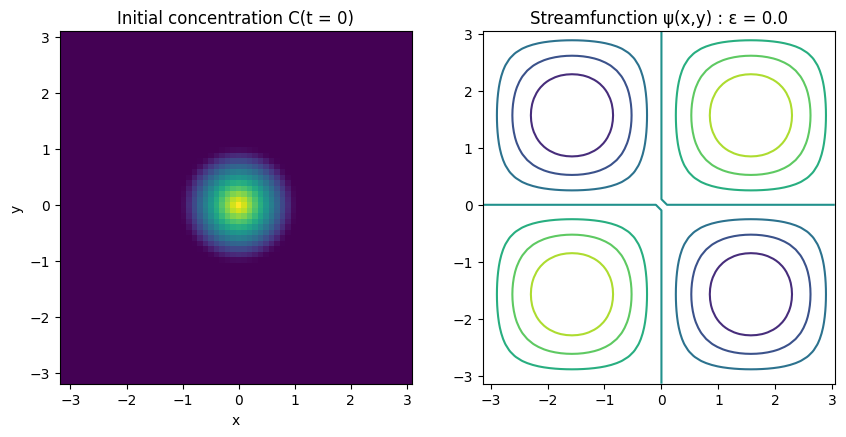

In [10]:
# Get the bases from the object "domain" and the state variables from the object "solver"
x, y = domain.grid(0), domain.grid(1)
C = solver.state['C']
Cx = solver.state['Cx']
Cy = solver.state['Cy']

# set initial condition
a = 20
C['g'] = np.log(1 + np.cosh(a)**2/np.cosh(a*np.sqrt(x**2+y**2))**2) / (2*a)
C.differentiate(0, out=Cx)
C.differentiate(1, out=Cy)

# plot initial condition and flow streamlines
C.set_scales(1, keep_data=True)
xx,yy = np.meshgrid(x,y,indexing='ij')
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(1,2,1)
ax.pcolormesh(xx, yy, C['g'])
ax.set(aspect=1,title='Initial concentration C(t = 0)',xlabel='x',ylabel='y')
ax = f.add_subplot(1,2,2)
ax.contour(xx, yy, np.sin(xx)*np.sin(yy) + eps*np.cos(xx)*np.cos(yy))
ax.set(aspect=1,title='Streamfunction ψ(x,y) : ε = ' + str(eps))

## Solving the problem

The logic controlling the main-loop of a Dedalus simulation occurs explicitly in the simulation script.  The `solver.ok` property can be used to halt an evolution loop once any of the specified stopping criteria have been met.  Let's timestep our problem until a halting condition is reached, copying the grid values of `C` every few iterations.  This should take less than a minute on most machines.

In [11]:
# Store data for final plot
C.set_scales(1, keep_data=True)
C_list = [np.copy(C['g'])]
t_list = [solver.sim_time]

In [12]:
# Main loop
while solver.ok:
    solver.step(dt)
    if solver.iteration % 50 == 0:
        C.set_scales(1, keep_data=True)
        C_list.append(np.copy(C['g']))
        t_list.append(solver.sim_time)
    if solver.iteration % 500 == 0:
        logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))

INFO:__main__:Iteration: 500, Time: 1.000000e+00, dt: 2.000000e-03


2024-09-29 01:07:34,967 __main__ 0/1 INFO :: Iteration: 500, Time: 1.000000e+00, dt: 2.000000e-03


INFO:__main__:Iteration: 1000, Time: 2.000000e+00, dt: 2.000000e-03


2024-09-29 01:07:46,338 __main__ 0/1 INFO :: Iteration: 1000, Time: 2.000000e+00, dt: 2.000000e-03


INFO:__main__:Iteration: 1500, Time: 3.000000e+00, dt: 2.000000e-03


2024-09-29 01:07:50,516 __main__ 0/1 INFO :: Iteration: 1500, Time: 3.000000e+00, dt: 2.000000e-03


INFO:__main__:Iteration: 2000, Time: 4.000000e+00, dt: 2.000000e-03


2024-09-29 01:07:54,157 __main__ 0/1 INFO :: Iteration: 2000, Time: 4.000000e+00, dt: 2.000000e-03


INFO:__main__:Iteration: 2500, Time: 5.000000e+00, dt: 2.000000e-03


2024-09-29 01:07:58,670 __main__ 0/1 INFO :: Iteration: 2500, Time: 5.000000e+00, dt: 2.000000e-03


INFO:__main__:Iteration: 3000, Time: 6.000000e+00, dt: 2.000000e-03


2024-09-29 01:08:02,647 __main__ 0/1 INFO :: Iteration: 3000, Time: 6.000000e+00, dt: 2.000000e-03


INFO:__main__:Iteration: 3500, Time: 7.000000e+00, dt: 2.000000e-03


2024-09-29 01:08:06,460 __main__ 0/1 INFO :: Iteration: 3500, Time: 7.000000e+00, dt: 2.000000e-03


INFO:__main__:Iteration: 4000, Time: 8.000000e+00, dt: 2.000000e-03


2024-09-29 01:08:10,320 __main__ 0/1 INFO :: Iteration: 4000, Time: 8.000000e+00, dt: 2.000000e-03


INFO:__main__:Iteration: 4500, Time: 9.000000e+00, dt: 2.000000e-03


2024-09-29 01:08:14,672 __main__ 0/1 INFO :: Iteration: 4500, Time: 9.000000e+00, dt: 2.000000e-03


INFO:__main__:Iteration: 5000, Time: 1.000000e+01, dt: 2.000000e-03


2024-09-29 01:08:18,272 __main__ 0/1 INFO :: Iteration: 5000, Time: 1.000000e+01, dt: 2.000000e-03


INFO:solvers:Simulation stop time reached.


2024-09-29 01:08:18,277 solvers 0/1 INFO :: Simulation stop time reached.


### Plotting the output

When the simulation is complete, we can plot the tracer concentration at sequential timesteps. Compare these snapshots with the plots of the advecting flow (or the streamlines) to get a sense for how the tracer is being moved by the flow.

101


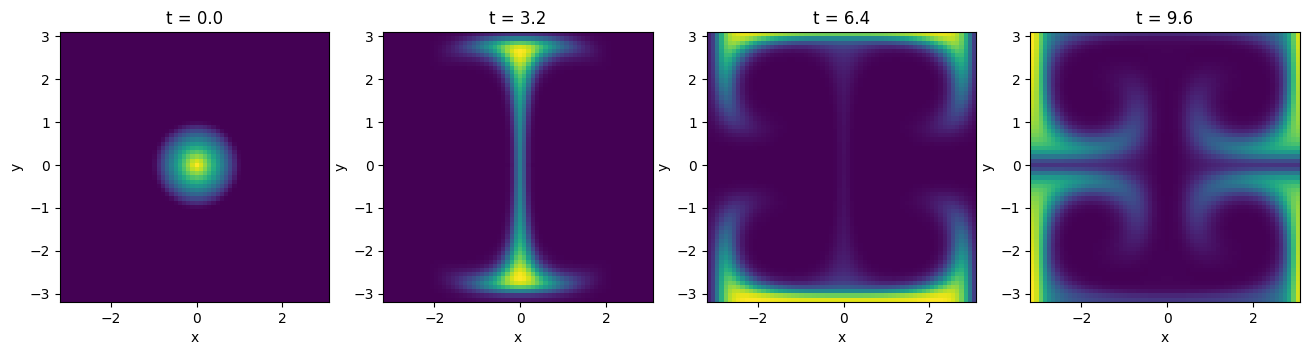

In [13]:
# Make plot of C
f = plt.figure(figsize=(16,4))
print(len(C_list))

for i in range(4):
    ax = f.add_subplot(1,4,i+1)
    ax.pcolormesh(xx, yy, C_list[i*32])
    ax.set(aspect=1,title='t = ' + str(round(t_list[i*32],1)),xlabel='x',ylabel='y')

We can also look at the time-evolution of integrated quantities, such as

- the total tracer concentration integrated over the domain $\langle C \rangle = \int \int C \, dx \, dy$

- the total tracer variance integrated over the domain $\langle C^2 \rangle = \int \int C^2 \, dx \, dy$.

The behaviour of these quantities with time might be a bit surprising. We will examine the reason for this behaviour at the end of this lab.

(0.0, 0.1)

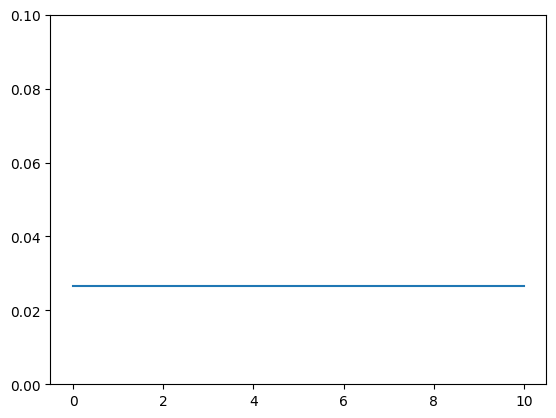

In [14]:
# plot average of C as a function of time
Cavg_list = np.sum(np.sum(C_list[0]))/nx**2

for i in range(len(C_list)):
    Cavg_list = np.append(Cavg_list,np.sum(np.sum(C_list[i]))/nx**2)

# Make plot of C average
t_plot = np.linspace(0,T,len(Cavg_list))
plt.plot(t_plot,Cavg_list)
plt.ylim(0,.1)

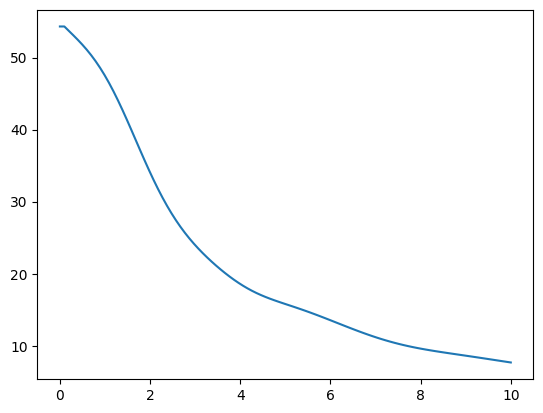

In [15]:
# plot variance of C as a function of time
Cvar_list = np.sum(np.sum(C_list[0]**2))

for i in range(len(C_list)):
    Cvar_list = np.append(Cvar_list,np.sum(np.sum(C_list[i]**2)))

# Make plot of C
t_plot = np.linspace(0,T,len(Cvar_list))
plt.plot(t_plot,Cvar_list)

## Now try it yourself

Use this notebook to experiment with the advection diffusion problem. Add your observations, comments, and calculations to the notebook by double clicking the cells to enter new text. You can then press **shift+enter** to turn the cell back into readable form.

When you make changes to the problem parameters or initial conditions, you will need to rebuild the solver. To do this, just re-run each cell from the beginning of the lab.

- Modify the value the diffusivity `K` to see how it changes the resulting concentration field and the variance. Does increasing `K` make the concentration decay faster or slower? Why?

- Try changing the shape of the flow by modifying the parameter `eps`. Which is more efficienty at dispersing the dye: closed cells, parallel shear flow, or something in between?

- Start with the advection-diffusion equation in Eulerian form
    
$$
\partial_t \, C + \mathbf{u \cdot \nabla} C = K \, \nabla^2 \, C.
$$

1. Show that the total tracer concentration integrated over the domain $\langle C \rangle = \int \int C \, dx \, dy$ remains constant in time for *any* incompressible flow $u$.

2. Show that the total tracer variance integrated over the domain $\langle C^2 \rangle = \int \int C^2 \, dx \, dy$ is a monotonically decreasing function of time for *any* incompressible flow $u$.

**Hint:** You will need to make use of the fact that the flow is incompressible $\mathbf{\nabla \cdot u} = 0$ and the domain is periodic.

From these results, we conclude that the effect of diffusion is to smooth out variations in the tracer concentration; however, no tracer is lost in this process, so the total amount of tracer remains constant.